## Lab 1.2 - Visualize Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. 

### Main objectives
After successful completion of the lab work students will be able to:
-   Analyze datasets with visualization techniques


### 1. Load data with real estate prices

In [1]:
# let's import pandas library and set options to be able to view data right in the browser
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')


In [2]:
# import math library which we'll need later for calculating metrics
import math
from sklearn.metrics import mean_squared_error

In [3]:
# load our dataset and see which data it contains.
spb_df = pd.read_table('spb.real.estate.archive.2018.tsv')

In [4]:
# let's look at random sample of the loaded dataset to understand what's inside
spb_df.sample(5)

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id
191930,698053933961356289,2017-07-03T00:00:00+03:00,2017-07-10T00:00:00+03:00,23000.0,13,False,1,False,70.0,10.0,15.0,30.0,0.0,2,2,"Россия, Санкт-Петербург, Кушелевская дорога, 3к1А",4155896670242508747
249559,9174606537144833375,2017-09-27T00:00:00+03:00,2018-02-23T00:00:00+03:00,3800000.0,4,False,1,False,40.4,12.6,17.8,NaN,NaN,1,2,"Россия, Ленинградская область, Всеволожский район, Заневское городское поселение, деревня Кудрово, Итальянский переулок, 4",8130593558849740384
42234,5450620,2016-02-24T00:00:00+03:00,2016-03-09T00:00:00+03:00,20000.0,18,False,1,False,38.0,8.0,18.0,NaN,10.0,2,2,"Россия, Ленинградская область, Всеволожский район, поселок Мурино, улица Шувалова, 5",6278327969890435989
401548,9174606537144984123,2018-07-17T00:00:00+03:00,2018-08-20T00:00:00+03:00,3500000.0,3,False,3,False,75.0,8.2,42.7,NaN,NaN,1,2,"Россия, Ленинградская область, Всеволожский район, деревня Гарболово, 290",702216226617099262
177468,1896730477279879296,2017-05-30T00:00:00+03:00,2017-06-30T00:00:00+03:00,40000.0,3,False,2,False,54.0,10.0,24.0,100.0,0.0,2,2,"Россия, Санкт-Петербург, улица Марата, 36-38",6140900113375514941


In [5]:
# let's check how much data to we have
len(spb_df)

429187

### 2. Prepare cleaned dataset with RENT data in St.Peterburg without Oblast 
<p>Use results of our analysis of the previous Lab Works for cleaning the dataset
<p>Reminder: offer_type column contains data to distinct rent from sell items, 2 stands for RENT, 1 for SELL


#### Prepare dataframe with rent data in city limits

In [6]:
rent_df = spb_df[spb_df.offer_type == 2].copy()
print("Total rent data size: {}".format(len(rent_df)))
rent_df_spb = rent_df[rent_df.unified_address.str.contains('Россия, Санкт-Петербург')].copy()
print("Rent data size in city limits: {}".format(len(rent_df_spb)))

Total rent data size: 171186
Rent data size in city limits: 156054


#### Calculate price per square meter, get median prices for house and find outliers with the help of this

In [7]:
# calculate price per sq m
rent_df_spb['price_per_sq_m'] = rent_df_spb.last_price/rent_df.area

##### Find median price per sq m per house

In [8]:
house_rent_df = rent_df_spb.groupby('unified_address').price_per_sq_m.median().reset_index()

In [9]:
house_rent_df.rename(columns = {'price_per_sq_m': 'house_price_sqm_median'}, inplace = True)

##### Merge rent data with house median prices and inspect outliers

In [10]:
rent_df_spb = rent_df_spb.merge(house_rent_df)

##### Clean data from the outliers - use results from Lab 1

In [11]:
rent_df_cleaned = rent_df_spb[~((rent_df_spb.price_per_sq_m/rent_df_spb.house_price_sqm_median) > 5)]
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned.last_price < 1000000]
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m > 3000) 
                                     & ((rent_df_cleaned.house_price_sqm_median < 1000) 
                                        | (rent_df_cleaned.house_price_sqm_median == rent_df_cleaned.price_per_sq_m)))]
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m < 250) 
                               & (rent_df_cleaned.house_price_sqm_median/rent_df_cleaned.price_per_sq_m >= 2))]
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m < 200) 
                                          & (rent_df_cleaned.price_per_sq_m == rent_df_cleaned.house_price_sqm_median))]

<AxesSubplot: xlabel='last_price'>

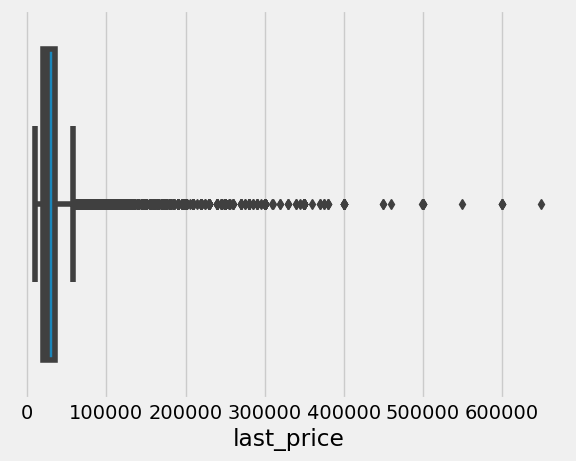

In [12]:
sns.boxplot(data=rent_df_cleaned, x="last_price")

<AxesSubplot: xlabel='last_price'>

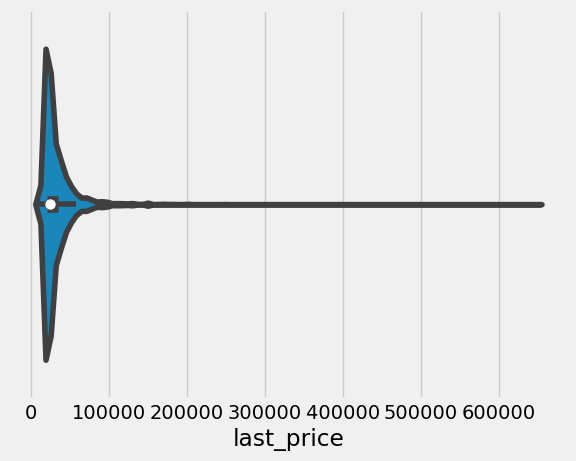

In [13]:
sns.violinplot(data=rent_df_cleaned, x="last_price")

In [14]:
def visualize_property(df, feature):
    fig, axs = plt.subplots(3, figsize = (10,8))
    
    #histogram
    axs[0].set_title('Histogram')
    df[feature].hist(ax = axs[0])
    
    #Q-Q plot
    axs[1].set_title('QQ')
    stats.probplot(df[feature], plot=axs[1])
    
    #Box-plot
    axs[2].set_title("Box plot")
    sns.boxplot(df[feature], ax = axs[2],orient="h")
    print("Skewness: %f" % df[feature].skew())
    print("Kurtosis: %f" % df[feature].kurt())

Skewness: 5.188733
Kurtosis: 50.765068


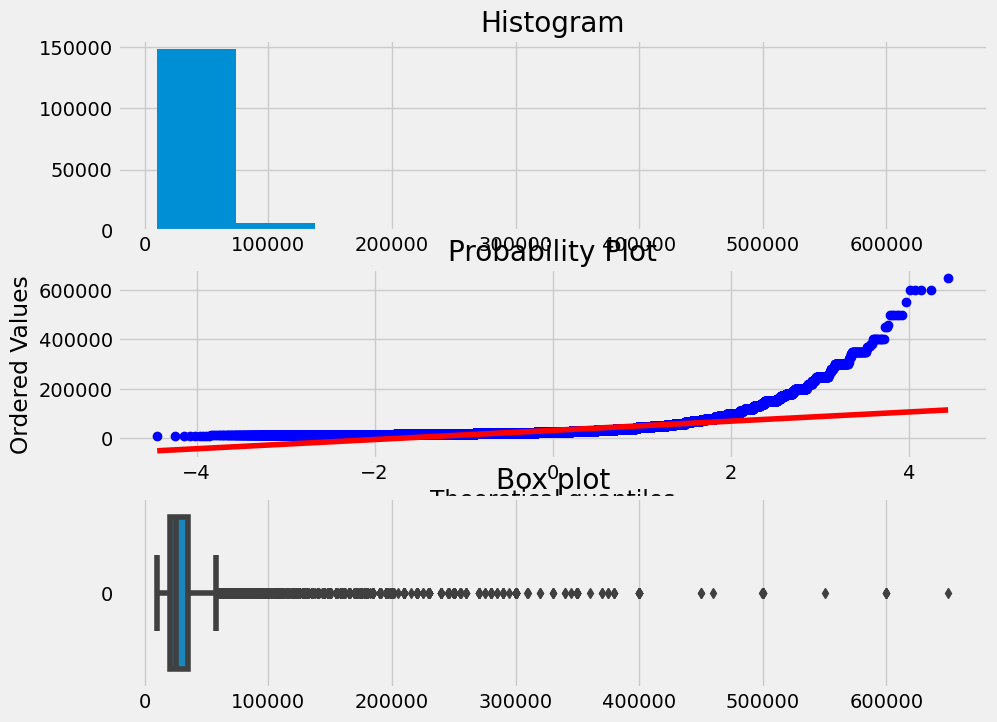

In [15]:
visualize_property(rent_df_cleaned, 'last_price')

In [16]:
rent_df_cleaned['last_price'].quantile(0.997)

200000.0

In [17]:
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned['last_price']<200000]

In [18]:
rent_df_cleaned.shape

(155392, 19)

Skewness: 3.078190
Kurtosis: 12.995784


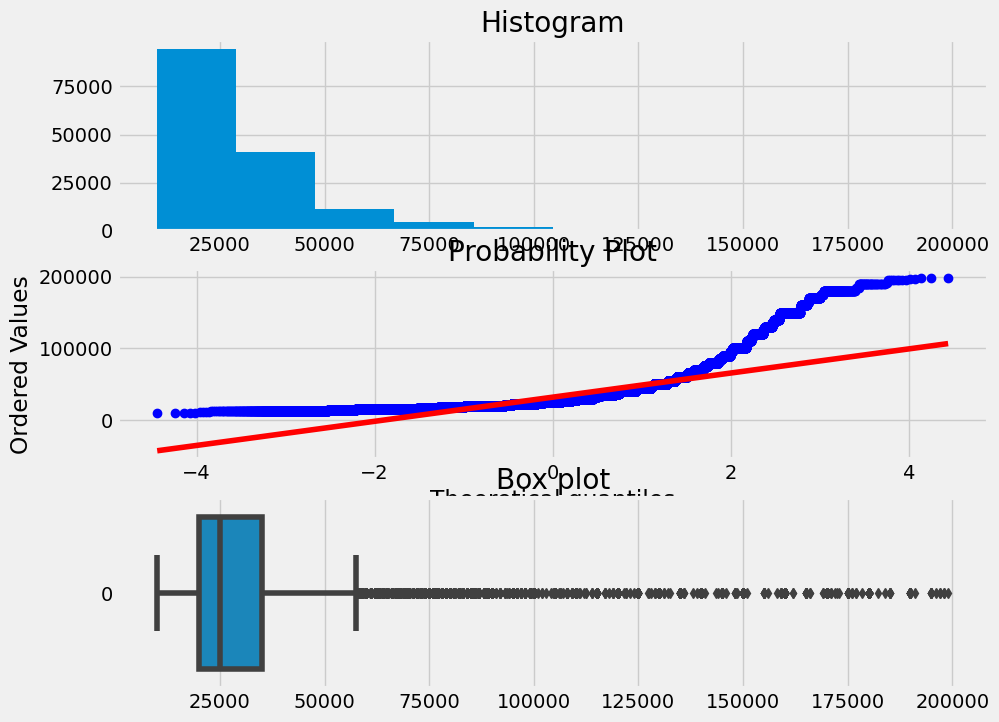

In [19]:
visualize_property(rent_df_cleaned, 'last_price')

Skewness: 1.108232
Kurtosis: 1.256939


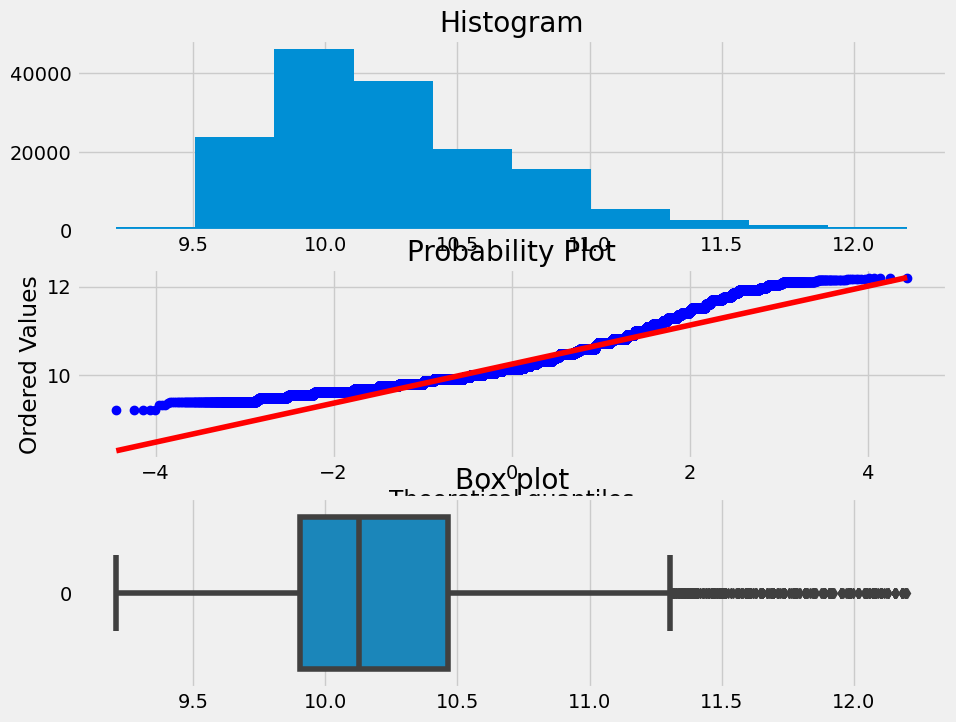

In [20]:
import numpy as np
rent_df_cleaned['last_price_log'] = np.log(rent_df_cleaned['last_price'])
visualize_property(rent_df_cleaned, 'last_price_log')

In [21]:
rent_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155392 entries, 0 to 156053
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_id                155392 non-null  int64  
 1   first_day_exposition    155392 non-null  object 
 2   last_day_exposition     155392 non-null  object 
 3   last_price              155392 non-null  float64
 4   floor                   155392 non-null  int64  
 5   open_plan               155392 non-null  bool   
 6   rooms                   155392 non-null  int64  
 7   studio                  155392 non-null  bool   
 8   area                    155392 non-null  float64
 9   kitchen_area            118364 non-null  float64
 10  living_area             123015 non-null  float64
 11  agent_fee               122840 non-null  float64
 12  renovation              102677 non-null  float64
 13  offer_type              155392 non-null  int64  
 14  category_type       

In [22]:
binary = [f for f in rent_df_cleaned.columns if rent_df_cleaned.dtypes[f] == 'bool']
print('binary variables: {}'.format(binary))
quantitative = [f for f in rent_df_cleaned.columns if rent_df_cleaned.dtypes[f] != 'object']
for f in binary:
    quantitative.remove(f)
print("quantitative variables: {}".format(quantitative))
qualitative = [f for f in rent_df_cleaned.columns if rent_df_cleaned.dtypes[f] == 'object']
print("qualitative variables: {}".format(qualitative))

binary variables: ['open_plan', 'studio']
quantitative variables: ['offer_id', 'last_price', 'floor', 'rooms', 'area', 'kitchen_area', 'living_area', 'agent_fee', 'renovation', 'offer_type', 'category_type', 'building_id', 'price_per_sq_m', 'house_price_sqm_median', 'last_price_log']
qualitative variables: ['first_day_exposition', 'last_day_exposition', 'unified_address']


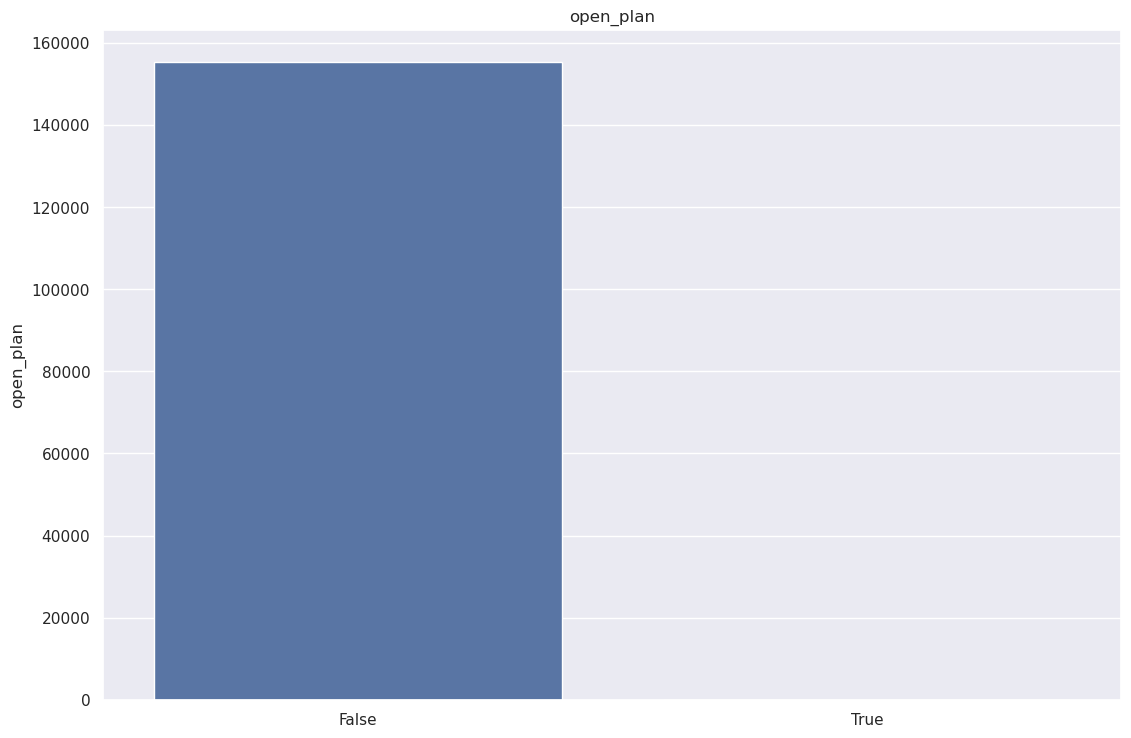

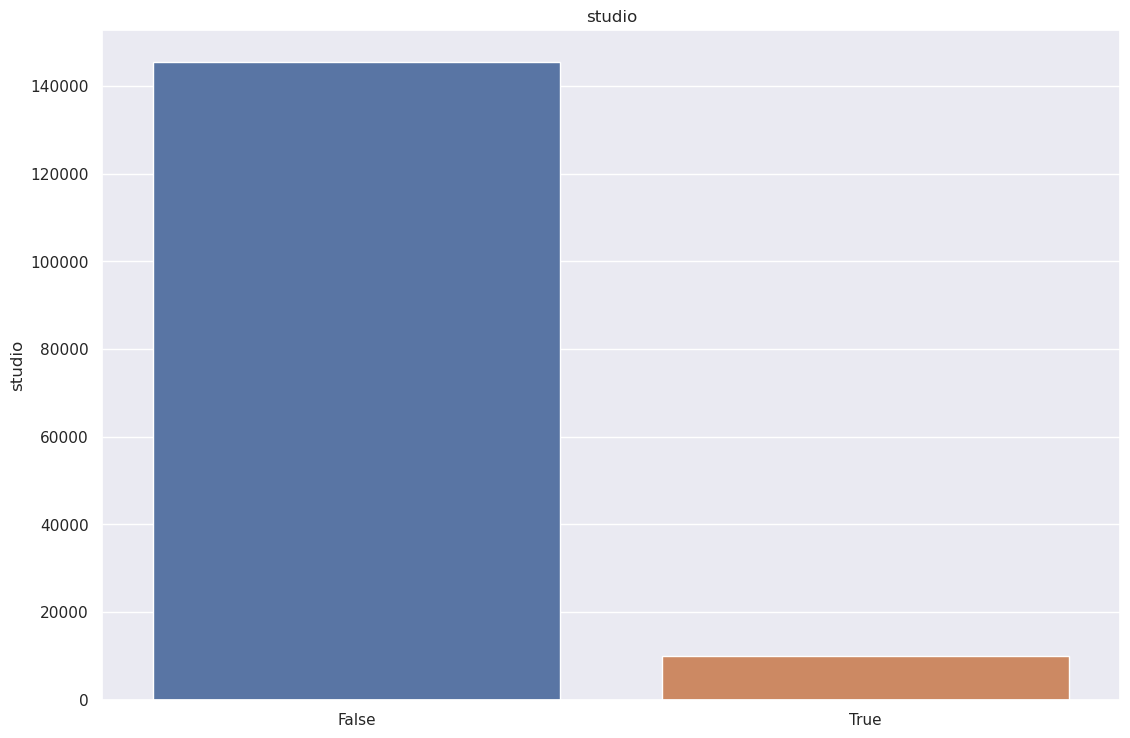

In [23]:
df_cat = rent_df_cleaned[['open_plan','studio']]

sns.set(rc={'figure.figsize':(11.7,8.27)})
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index, y=df_cat[i].value_counts()).set_title(i)
    plt.show()

count    155392.000000
mean         53.358246
std          24.097810
min          11.000000
25%          38.000000
50%          46.000000
75%          62.000000
max         200.000000
Name: area, dtype: float64

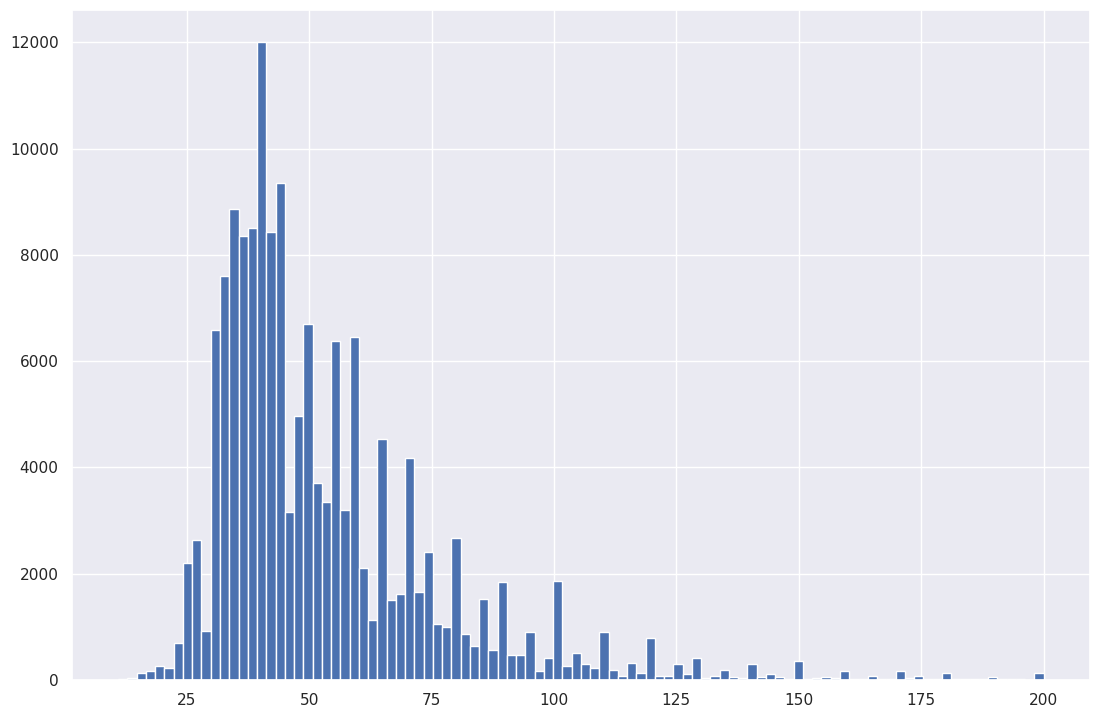

In [29]:
rent_df_cleaned['area'].hist(bins=100)
rent_df_cleaned['area'] .describe()

count    155392.000000
mean          6.698498
std           4.978305
min           1.000000
25%           3.000000
50%           5.000000
75%           9.000000
max          92.000000
Name: floor, dtype: float64

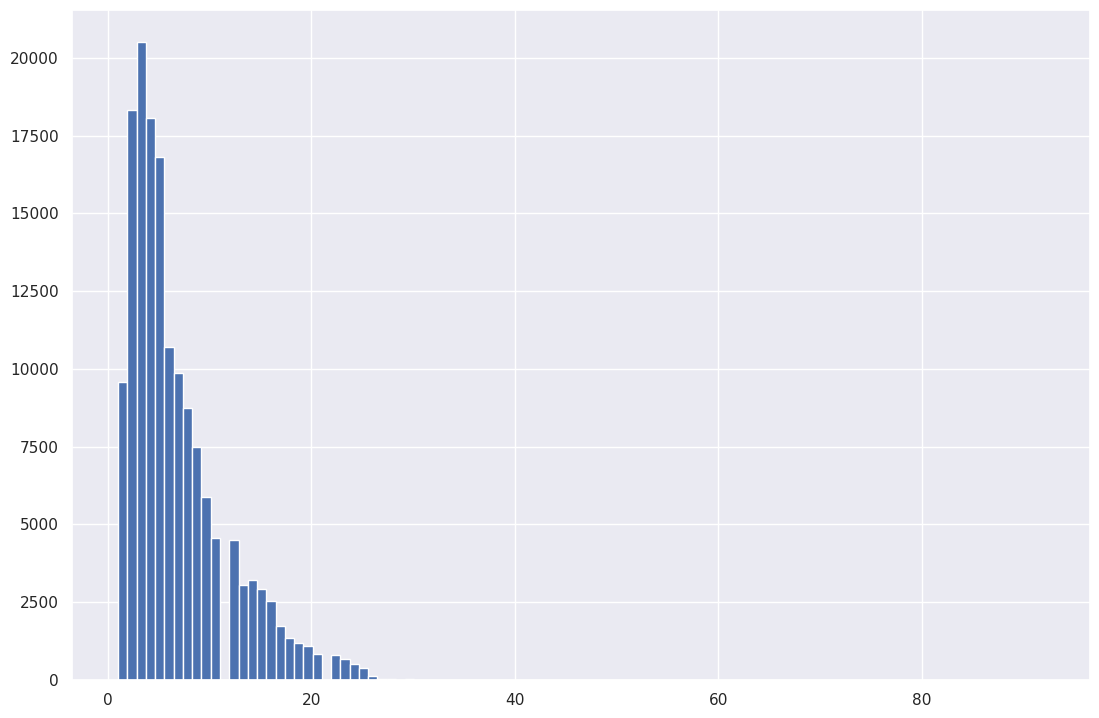

In [27]:
rent_df_cleaned['floor'].hist(bins=100)
rent_df_cleaned['floor'] .describe()

count    155392.000000
mean          1.599297
std           0.872410
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: rooms, dtype: float64

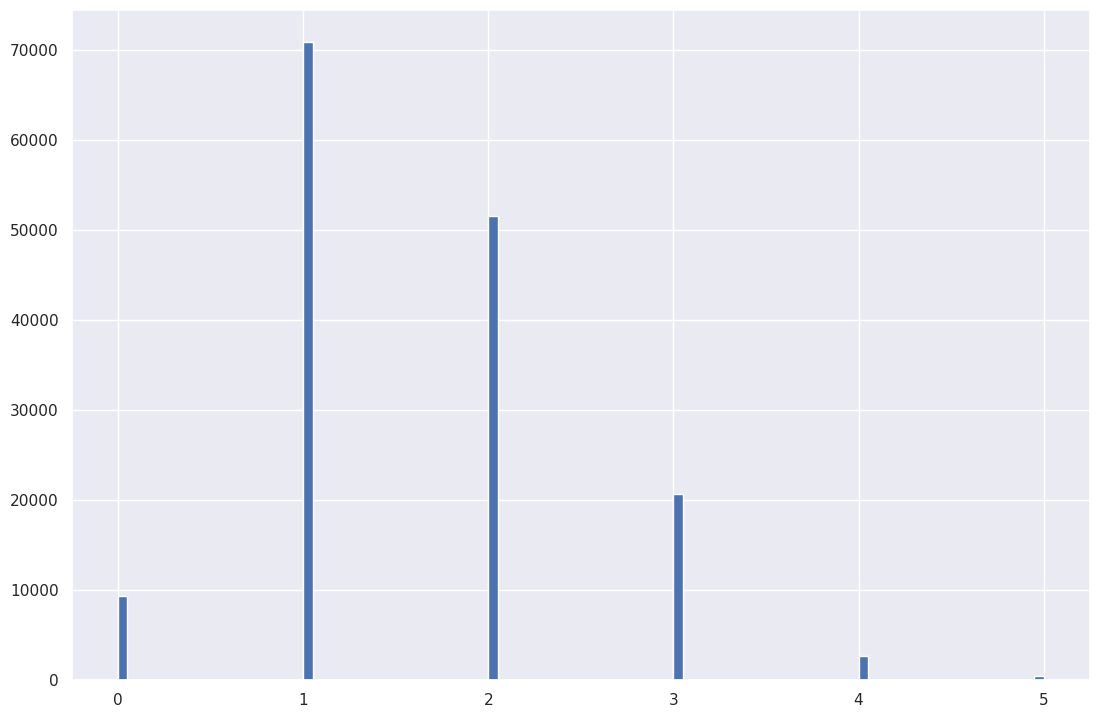

In [26]:
rent_df_cleaned['rooms'].hist(bins=100)
rent_df_cleaned['rooms'] .describe()

<AxesSubplot: >

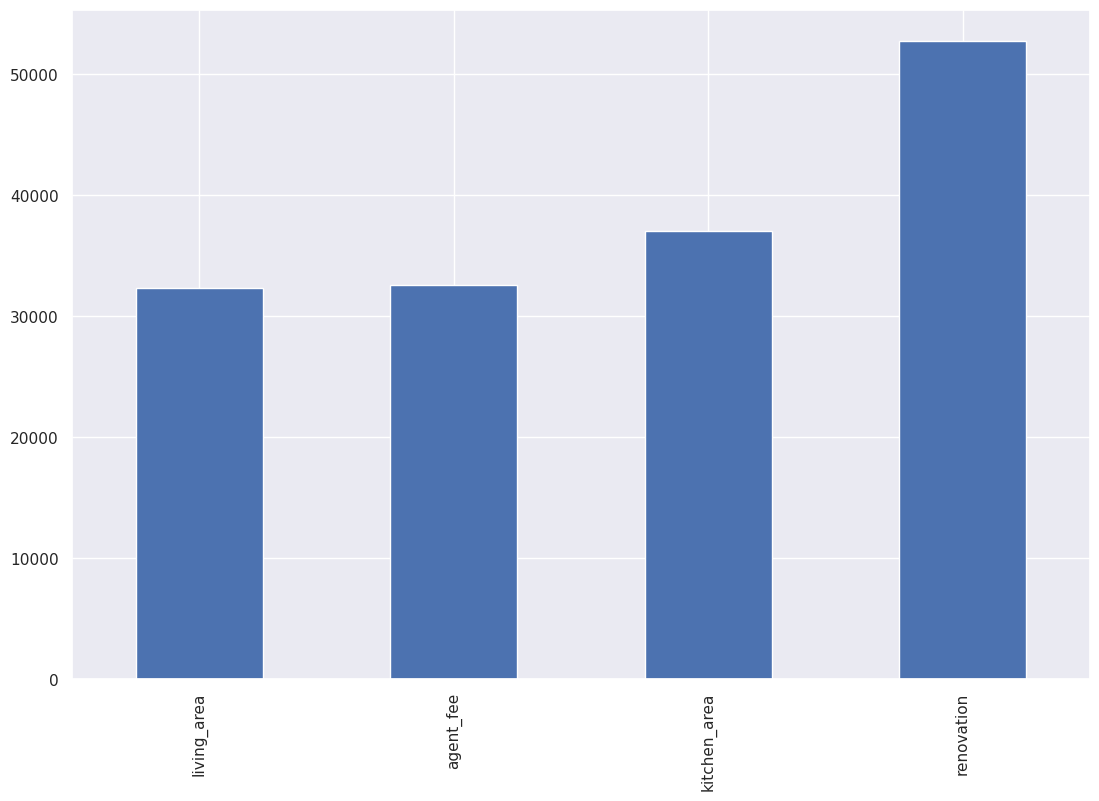

In [30]:
missing = rent_df_cleaned.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [31]:
rent_df_cleaned[rent_df_cleaned['living_area'].isnull()].head()

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id,price_per_sq_m,house_price_sqm_median,last_price_log
8,4181888598340999168,2018-01-05T00:00:00+03:00,2018-01-16T00:00:00+03:00,26000.0,12,False,1,False,36.0,NaN,NaN,NaN,NaN,2,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,722.222222,512.820513,10.165852
26,1166248862458040064,2018-03-19T00:00:00+03:00,2018-04-18T00:00:00+03:00,22000.0,12,False,1,False,32.0,NaN,NaN,NaN,NaN,2,2,"Россия, Санкт-Петербург, Лужская улица, 8",5887402119500981764,687.500000,568.468556,9.998798
29,5153793897333863110,2018-03-28T00:00:00+03:00,2018-04-02T00:00:00+03:00,19000.0,7,False,1,False,35.0,8.0,NaN,99.0,NaN,2,2,"Россия, Санкт-Петербург, Лужская улица, 8",5887402119500981764,542.857143,568.468556,9.852194
41,6720278181597658625,2017-01-30T00:00:00+03:00,2017-01-30T00:00:00+03:00,65000.0,14,False,3,False,110.0,NaN,NaN,60.0,0.0,2,2,"Россия, Санкт-Петербург, Морская набережная, 37к2",1756484481996641220,590.909091,584.117647,11.082143
48,3376106655955437495,2016-12-14T00:00:00+03:00,2017-05-24T00:00:00+03:00,70000.0,7,False,3,False,160.0,30.0,NaN,100.0,0.0,2,2,"Россия, Санкт-Петербург, Морская набережная, 37к2",1756484481996641220,437.500000,584.117647,11.156251


In [32]:
rent_df_cleaned['offer_type'].value_counts()

2    155392
Name: offer_type, dtype: int64

In [33]:
rent_df_cleaned['category_type'].value_counts()

2    155392
Name: category_type, dtype: int64

In [34]:
rent_df_cleaned.drop(columns=['category_type','offer_type'], inplace=True)

In [35]:
rent_df_cleaned.drop(columns=['agent_fee'], inplace=True)

In [36]:
rent_df_cleaned.head()

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,unified_address,building_id,price_per_sq_m,house_price_sqm_median,last_price_log
0,1100202,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,False,1,False,28.0,8.0,20.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,714.285714,512.820513,9.903488
1,4593125,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,False,2,False,59.0,10.0,35.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,406.779661,512.820513,10.085809
2,4586184,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,False,1,False,36.0,9.0,17.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,500.000000,512.820513,9.798127
3,5308071,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,False,1,False,39.0,10.0,18.0,0.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,461.538462,512.820513,9.798127
4,7534283612538021121,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,False,1,False,36.0,8.0,18.0,11.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,527.777778,512.820513,9.852194


In [37]:
rent_df_cleaned['renovation'].fillna(0.0, inplace=True)

<AxesSubplot: >

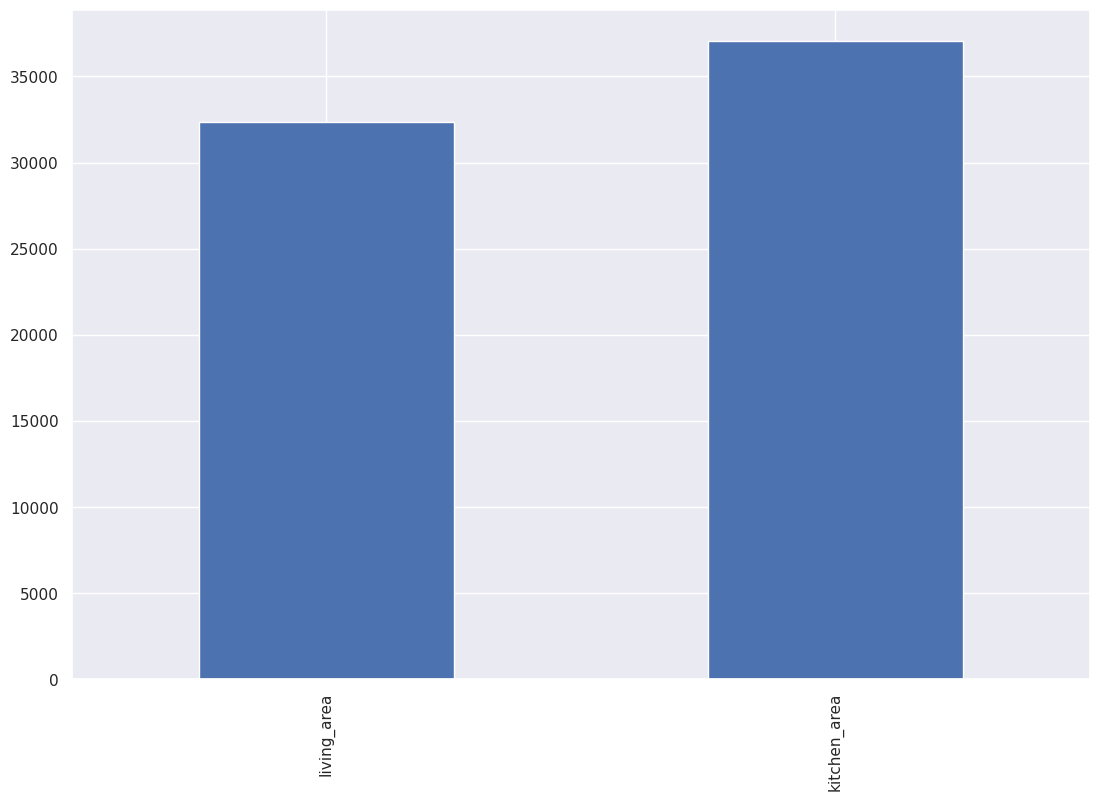

In [38]:
missing = rent_df_cleaned.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [39]:
rent_df_cleaned.drop(columns=['offer_id','price_per_sq_m','house_price_sqm_median'], inplace=True)

In [40]:
rent_df_cleaned.head()

,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,unified_address,building_id,last_price_log
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,False,1,False,28.0,8.0,20.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,9.903488
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,False,2,False,59.0,10.0,35.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,10.085809
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,False,1,False,36.0,9.0,17.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,9.798127
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,False,1,False,39.0,10.0,18.0,0.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,9.798127
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,False,1,False,36.0,8.0,18.0,11.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,9.852194


<AxesSubplot: xlabel='last_price', ylabel='area'>

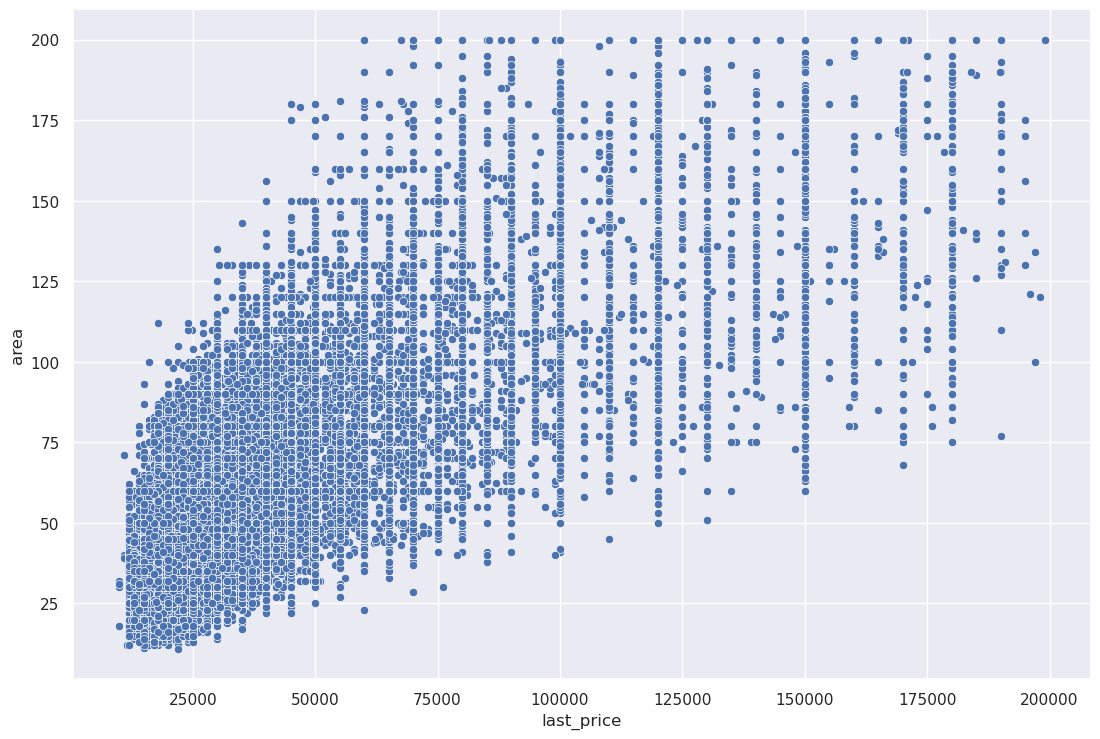

In [41]:
sns.scatterplot(x = rent_df_cleaned['last_price'], y = rent_df_cleaned['area'])

/tmp/ipykernel_333/2168765669.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rent_df_cleaned.corr(), annot = True, vmin=-1, vmax=1)


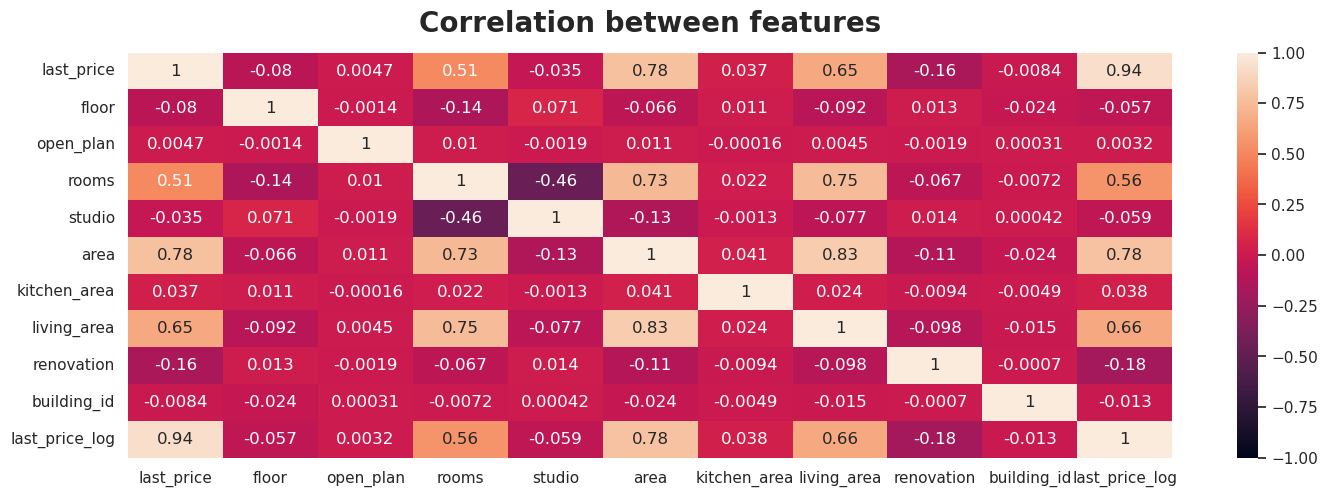

In [45]:
plt.figure(figsize = (15, 5)) 
sns.heatmap(rent_df_cleaned.corr(), annot = True, vmin=-1, vmax=1)
plt.title('Correlation between features', fontweight = "bold", fontsize = 20, pad = 15)
plt.show();

In [46]:
categorical = ['floor','open_plan', 'rooms','renovation','studio']

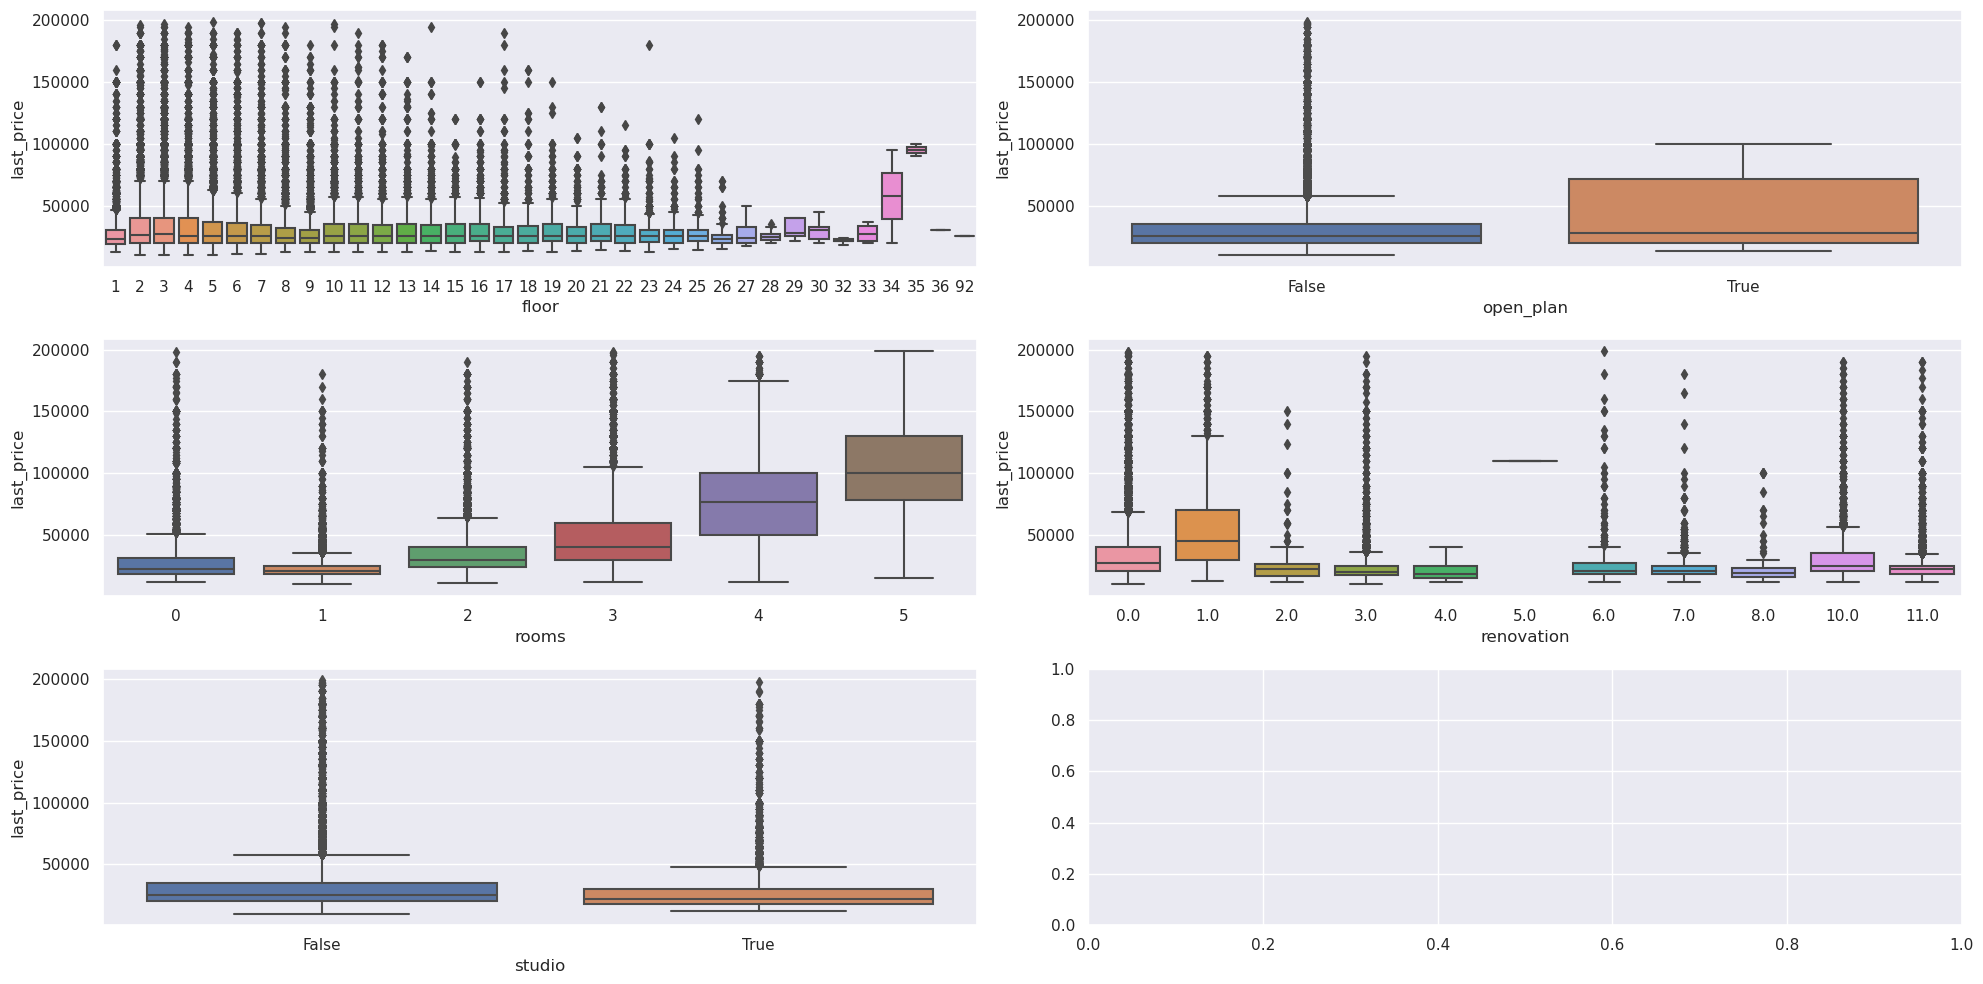

In [47]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,10))
for idx, feat in enumerate(categorical):
    ax = axes[int(idx/2),idx%2]
    sns.boxplot(x=feat, y='last_price', data=rent_df_cleaned, ax=ax)
    ax.set_xlabel(feat)
fig.tight_layout()

In [48]:
rent_df_cleaned['open_plan'] = rent_df_cleaned['open_plan'].astype('int')
rent_df_cleaned['studio'] = rent_df_cleaned['studio'].astype('int')

In [49]:
unified_address = rent_df_cleaned.pop('unified_address')

In [50]:
rent_df_cleaned.head(5)

,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,building_id,last_price_log
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,0,1,0,28.0,8.0,20.0,3.0,6719200042030752141,9.903488
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,0,2,0,59.0,10.0,35.0,3.0,6719200042030752141,10.085809
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,0,1,0,36.0,9.0,17.0,3.0,6719200042030752141,9.798127
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,0,1,0,39.0,10.0,18.0,0.0,6719200042030752141,9.798127
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,0,1,0,36.0,8.0,18.0,11.0,6719200042030752141,9.852194


In [51]:
rent_df_cleaned.drop(columns=['kitchen_area','living_area','building_id','floor','studio'], inplace=True)

In [52]:
rent_df_cleaned.head()

,first_day_exposition,last_day_exposition,last_price,open_plan,rooms,area,renovation,last_price_log
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,0,1,28.0,3.0,9.903488
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,0,2,59.0,3.0,10.085809
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,0,1,36.0,3.0,9.798127
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,0,1,39.0,0.0,9.798127
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,0,1,36.0,11.0,9.852194


/tmp/ipykernel_333/3298013718.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rent_df_cleaned.corr(), annot = True, vmin=-1, vmax=1)


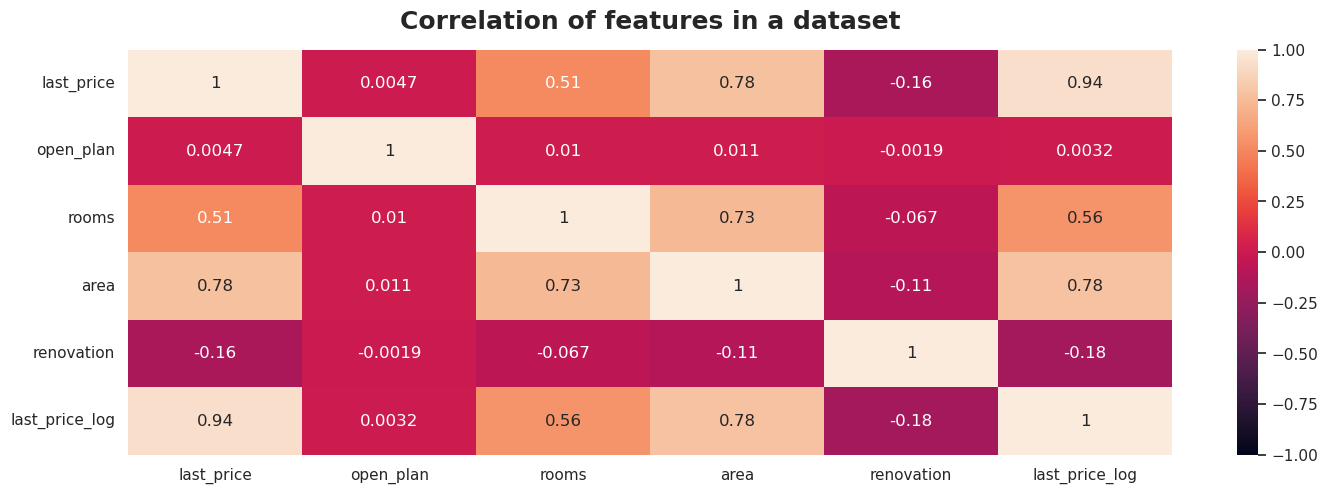

In [53]:
plt.figure(figsize = (15, 5)) 
sns.heatmap(rent_df_cleaned.corr(), annot = True, vmin=-1, vmax=1)
plt.title('Correlation of features in a dataset', fontweight = "bold", fontsize = 18, pad = 15)
plt.show();

In [54]:
rent_df_cleaned.to_csv('cleaned_dataset.csv', index=False)